Check the version of python and packages:

In [1]:
!python --version

Python 3.7.3


In [2]:
# !pip install scikit-multilearn

In [3]:
# !pip install -U imbalanced-learn

In [4]:
# !pip3 install xgboost
# !brew install libomp

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

In [6]:
from model import DenseNet, Model
from evaluate import accuracy_score, precision_score, recall_score, f1_score

In [7]:
SEED = 123
np.random.seed(SEED)
torch.manual_seed(SEED)

In [8]:
data_dir = './DATA/lish-moa/'

****
# Table of Contents  
1. Load the dataset   
2. Preprocessing   
3. Models  
    3.1 Neural Network    
    3.2 Random Forest  
    3.3 Classifier Chain  
        3.3.1 Random Forest  
        3.3.2 Logistic Regression   
        3.3.3 Gradient Boost
    3.4 Binary Relevance   
        3.4.1 Random Forest  
        3.4.2 Gradient Boost
        3.4.3 Logistic Regression
****

## Load the dataset

In [9]:
X = pd.read_csv(data_dir+'train_features.csv', index_col='sig_id')
y = pd.read_csv(data_dir+'train_targets_scored.csv', index_col='sig_id')

In [10]:
y.sum(axis=1).value_counts()

1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
dtype: int64

In [11]:
print(X.shape)
print(y.shape)

(23814, 875)
(23814, 206)


In [12]:
# Number of NA in X, and y
print(X.isnull().sum().sum())
print(y.isnull().sum().sum())

0
0


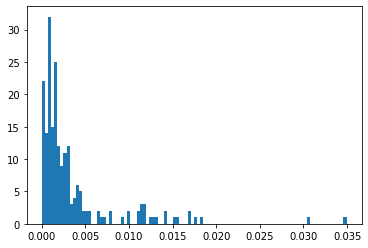

In [13]:
# percentage of 1's in each column of y
one_perc = y.apply(lambda x: x.sum()/len(y))
plt.figure()
plt.hist(one_perc, bins=100);

In [14]:
X.cp_type.value_counts()

trt_cp         21948
ctl_vehicle     1866
Name: cp_type, dtype: int64

In [15]:
X.cp_dose.value_counts()

D1    12147
D2    11667
Name: cp_dose, dtype: int64

## Preprocessing

In [16]:
# One-hot encoding for cp_type and cp_dose
X['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
X['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)

In [17]:
# split into training set and test set
SEED = 123
np.random.seed(SEED)

ids = X.index.values.copy()
np.random.shuffle(ids)

train_perc, val_perc, test_perc = 0.7, 0.1, 0.2
train_id = ids[:round(len(ids)*train_perc)]
val_id = ids[round(len(ids)*train_perc):round(len(ids)*(train_perc+val_perc))]
test_id = ids[round(len(ids)*(train_perc+val_perc)):]

X_train = X.loc[train_id]
X_val = X.loc[val_id]
X_test = X.loc[test_id]

y_train = y.loc[train_id]
y_val = y.loc[val_id]
y_test = y.loc[test_id]

In [18]:
# normalize the data
scaler = StandardScaler()
X_train_norm = pd.DataFrame(scaler.fit_transform(X_train))
X_train_norm.columns = X_train.columns
X_train_norm.index = X_train.index

X_val_norm = pd.DataFrame(scaler.transform(X_val))
X_val_norm.columns = X_val.columns
X_val_norm.index = X_val.index

X_test_norm = pd.DataFrame(scaler.transform(X_test))
X_test_norm.columns = X_test.columns
X_test_norm.index = X_test.index

In [19]:
# examine the class skewness in the training and testing set
for icol in range(y_train.shape[1]):
    print(icol)
    train_icol = y_train.iloc[:,icol]
    print('Training set: {}'.format(round(sum(train_icol)/len(train_icol), 6)) )
    test_icol = y_test.iloc[:,icol]
    print('Test set: {}'.format(round(sum(test_icol)/len(test_icol), 6)) )
    print()

0
Training set: 0.00072
Test set: 0.00063

1
Training set: 0.00072
Test set: 0.00126

2
Training set: 0.00102
Test set: 0.00105

3
Training set: 0.007678
Test set: 0.008398

4
Training set: 0.012657
Test set: 0.013017

5
Training set: 0.002879
Test set: 0.004409

6
Training set: 0.002519
Test set: 0.00168

7
Training set: 0.003719
Test set: 0.005039

8
Training set: 0.00048
Test set: 0.00063

9
Training set: 0.010918
Test set: 0.013017

10
Training set: 0.015717
Test set: 0.013857

11
Training set: 0.002759
Test set: 0.002519

12
Training set: 0.00024
Test set: 0.00021

13
Training set: 0.00168
Test set: 0.00084

14
Training set: 0.00042
Test set: 0.00042

15
Training set: 0.00042
Test set: 0.00063

16
Training set: 0.00228
Test set: 0.00126

17
Training set: 0.003419
Test set: 0.003569

18
Training set: 0.003659
Test set: 0.002729

19
Training set: 0.0018
Test set: 0.00105

20
Training set: 0.00132
Test set: 0.0021

21
Training set: 0.002939
Test set: 0.002939

22
Training set: 0.0001

## Models  

### Model 1: Neural Network

In [31]:
params_net = {'input_size': X_train_norm.shape[1],
             'hidden_size': [512, 512, 256, 128 ,256, 512, 1024],
             'output_size': y_train.shape[1],
             'dropout': 0.01}

params_fit = {'X':X_train_norm,
             'y': y_train,
             'epoch': 10,
             'lr': 5e-6,
             'batch_size':128,
             'L2': 0,
             'pos_weight':50,
             'verbose':True}

net = DenseNet(**params_net)
model = Model(net)
model.fit(**params_fit)

Epoch [1, 0] : loss 1.047478199005127
Epoch [1, 3840] : loss 1.05042564868927
Epoch [1, 7680] : loss 1.0482022762298584
Epoch [1, 11520] : loss 1.057258129119873
Epoch [1, 15360] : loss 1.056621789932251
Epoch [2, 0] : loss 1.0446748733520508
Epoch [2, 3840] : loss 1.0472965240478516
Epoch [2, 7680] : loss 1.0443134307861328
Epoch [2, 11520] : loss 1.0522059202194214
Epoch [2, 15360] : loss 1.049384593963623
Epoch [3, 0] : loss 1.031517505645752
Epoch [3, 3840] : loss 1.030834436416626
Epoch [3, 7680] : loss 1.0171416997909546
Epoch [3, 11520] : loss 1.0096237659454346
Epoch [3, 15360] : loss 0.9825803637504578
Epoch [4, 0] : loss 0.9295281767845154
Epoch [4, 3840] : loss 0.8986634016036987
Epoch [4, 7680] : loss 0.858842134475708
Epoch [4, 11520] : loss 0.8441187739372253
Epoch [4, 15360] : loss 0.8327736258506775
Epoch [5, 0] : loss 0.8097099661827087
Epoch [5, 3840] : loss 0.8154553174972534
Epoch [5, 7680] : loss 0.8103313446044922
Epoch [5, 11520] : loss 0.8212631940841675
Epoch [

In [32]:
y_train_predict = model.predict(X_train_norm, 0.45)
# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
y_test_predict = model.predict(X_test_norm, 0.5)
# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
0.05716523101018011
Recall: 
0.08687244328746746
F1: 
0.06895533843020338


In [34]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
20432


In [ ]:
# todo: grid search for pos_weight

### Model 2: Random Forest

In [84]:
# todo: define class-weight based 
weight_ratio = 50
class_weight = [{0:1, 1:round(len(value)/sum(value)-1)* weight_ratio} for _, value in y_train.iteritems()]

# class_weight = [{0:1, 1:50}]*y_train.shape[1]

rfc = RandomForestClassifier(n_estimators = 100,
                             max_depth = 20,
                             class_weight = 'balanced_subsample',
                             random_state=100)
rfc.fit(X_train, y_train);

In [85]:
y_train_predict = rfc.predict(X_train)

# print('Accuracy: ')
# print(accuracy_score(y_train, y_train_predict))
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))

print()

y_test_predict = rfc.predict(X_test)

# print('Accuracy: ')
# print(accuracy_score(y_test, y_test_predict))
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

Precision: 
1.0
Recall: 
0.2786165860914838
F1: 
0.4358094351695655

Precision: 
0.9689265536723164
Recall: 
0.1009417304296645
F1: 
0.1828358208955224


In [86]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
3746

3398
354


### Model 3 : Classifier Chains   
#### Model 3.1 : Random Forest

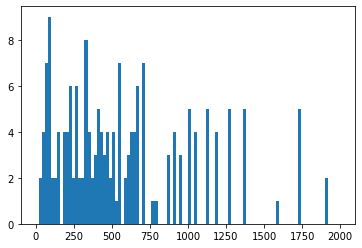

In [76]:
neg_vs_pos = [round(len(y)/sum(y)-1) for _, y in y_train.iteritems()];
plt.figure()
plt.hist(neg_vs_pos, bins=100, range = (0, 2000));

In [77]:
np.sum(np.array(neg_vs_pos)*0.76>8000)

2

In [72]:
weight_ratio = 0.76
max_depth = 3
max_features = 20
n_estimators = 120
min_samples_leaf = 1

y_train_predict = np.array([])
y_test_predict = np.array([])
model_chain = []

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X = X_train_val.values
X2 = X_test.values
for _, y in tqdm(y_train_val.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    rfc_2 = RandomForestClassifier(n_estimators = n_estimators,
                                  max_depth = max_depth,
                                  max_features = max_features,
                                  min_samples_leaf  = min_samples_leaf,
                                  class_weight = class_weight,
                                  n_jobs = 3,
                                  random_state=100);
    rfc_2.fit(X, y);
    
    y_predict = rfc_2.predict(X).reshape((-1, 1))
    y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    X = np.concatenate((X, y_predict), axis=1)
    X2 = np.concatenate((X2, y_predict2), axis=1)
    model_chain.append(rfc_2)

206it [13:05,  3.81s/it]


In [90]:
# # inference
# y_train_predict = np.array([])
# y_test_predict = np.array([])

# X_train_val = pd.concat([X_train, X_val])
# X = X_train_val.values
# X2 = X_test.values
# for rfc_2 in model_chain:
#     y_predict = rfc_2.predict(X).reshape((-1, 1))
#     y_predict2 = rfc_2.predict(X2).reshape((-1,1))
#     if y_test_predict.size == 0:
#         y_test_predict = y_predict2
#     else:
#         y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
#     if y_train_predict.size == 0:
#         y_train_predict = y_predict
#     else:
#         y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
#     X = np.concatenate((X, y_predict), axis=1)
#     X2 = np.concatenate((X2, y_predict2), axis=1)

In [ ]:
print('weight_ratio: ', weight_ratio, ' max_depth: ', max_depth, ' max_features:',max_features, ' n_estimators:',n_estimators, ' min_samples_leaf:',min_samples_leaf)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

In [74]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
13838

3398
2563


#### Model 3.2 : Logistic Regression

In [82]:
weight_ratio = 0.5
penalty = 'l1'
C = 0.5
y_train_predict = np.array([])
y_test_predict = np.array([])
model_chain_lr = []

X_train_val_norm = pd.concat([X_train_norm, X_val_norm])
y_train_val = pd.concat([y_train, y_val])
X = X_train_val_norm.values
X2 = X_test_norm.values
for _, y in tqdm(y_train_val.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    lr_1 = LogisticRegression(penalty = penalty,
                            C = C,
                            class_weight = class_weight,
                            n_jobs = -1,
                            solver = 'saga',
                            random_state = 100)
    lr_1.fit(X, y);
    
    y_predict = lr_1.predict(X).reshape((-1, 1))
    y_predict2 = lr_1.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    scaler = StandardScaler()
    X = np.concatenate((X, scaler.fit_transform(y_predict)), axis=1)
    X2 = np.concatenate((X2, scaler.transform(y_predict2)), axis=1)
    model_chain_lr.append(lr_1)

206it [1:24:49, 24.71s/it]


In [83]:
print('weight_ratio:',weight_ratio, 'penalty:',penalty, ' C:',C, ')
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

penalty: l1  C: 0.5  posi_weight: 25
Precision: 
0.28820592621409585
Recall: 
0.9918185198958721
F1: 
0.44662893123890546

Precision: 
0.10052567731500202
Recall: 
0.3658034137728075
F1: 
0.15771109560362875


In [84]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
46269

3398
12365


#### Model 3.3 : Gradient Boost

In [96]:
weight_ratio = 0.76
n_estimators = 120
max_depth = 5
early_stopping_rounds = 4


y_train_predict = np.array([])
y_test_predict = np.array([])
model_chain_gb = []

X_train, X_val, 

X = X_train.values
X1 = X_val.values
X2 = X_test.values
for i, y in tqdm(y_train.iteritems()):
    # class_weight for each target column
    scale_pos_weight = min(round(len(y)/sum(y)-1)*weight_ratio, 8000)
    
    gbc = XGBClassifier(n_estimators = n_estimators,
                        max_depth = max_depth,
                        scale_pos_weight  = scale_pos_weight,
                        n_jobs = -1,
                        random_state=100);
    eval_set = [(X1, y_val[i].values)]
    gbc.fit(X, y, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds = early_stopping_rounds, verbose=False);
    
    y_predict = gbc.predict(X).reshape((-1,1))
    y_predict1 = gbc.predict(X1).reshape((-1,1))
    y_predict2 = gbc.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    X = np.concatenate((X, y_predict), axis=1)
    X1 = np.concatenate((X1, y_predict1), axis=1)
    X2 = np.concatenate((X2, y_predict2), axis=1)
    model_chain_gb.append(gbc)




0it [00:00, ?it/s]


1it [00:38, 38.64s/it]


2it [01:15, 38.02s/it]


3it [01:57, 39.25s/it]


4it [03:15, 50.85s/it]


5it [04:46, 62.96s/it]


6it [05:39, 60.04s/it]


7it [06:42, 60.80s/it]


8it [07:42, 60.63s/it]


9it [08:23, 54.60s/it]


10it [09:47, 63.62s/it]


11it [11:41, 78.63s/it]


12it [12:27, 68.96s/it]


13it [12:56, 56.83s/it]


14it [13:54, 57.37s/it]


15it [14:36, 52.65s/it]


16it [15:08, 46.50s/it]


17it [16:10, 51.01s/it]


18it [17:17, 55.77s/it]


19it [18:21, 58.45s/it]


20it [19:19, 58.30s/it]


21it [20:07, 55.17s/it]


22it [21:07, 56.53s/it]


23it [21:32, 47.25s/it]


24it [22:26, 49.24s/it]


25it [23:02, 45.25s/it]


26it [23:43, 44.02s/it]


27it [24:16, 40.48s/it]


28it [25:00, 41.64s/it]


29it [26:05, 48.63s/it]


30it [27:08, 52.91s/it]


31it [27:57, 51.88s/it]


32it [29:03, 55.96s/it]


33it [29:55, 54.75s/it]


34it [30:28, 48.38s/it]


35it [30:57, 42.38s/it]


36it [31:24, 37.90s/it]


37it [32:20, 43.45s/it]


38it [33:01, 42.61s/it]

In [97]:
print('weight_ratio:',weight_ratio, ' n_estimators:',n_estimators, ' max_depth:', max_depth, ' early_stopping_rounds:', early_stopping_rounds)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

weight_ratio: 0.76  n_estimators: 120  max_depth: 5  early_stopping_rounds: 4
Precision: 
0.9945997928687675
Recall: 
1.0
F1: 
0.9972925861365575

Precision: 
0.7901345291479821
Recall: 
0.25927015891701
F1: 
0.3904276534456016


In [98]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
13518

3398
1115


### Model 4: Binary Relavance    
#### Model 4.1: Random Forest

In [87]:
weight_ratio = 0.7
max_depth = 6

y_train_predict = np.array([])
y_test_predict = np.array([])
model_list = []

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
X = X_train_val.values
X2 = X_test.values
scaler = StandardScaler()
for _, y in tqdm(y_train.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    rfc_2 = RandomForestClassifier(n_estimators = 100,
                                  max_depth = max_depth,
                                  class_weight = class_weight,
                                  n_jobs = 3,
                                  random_state=100);
    rfc_2.fit(X, y);
    
    y_predict = rfc_2.predict(X).reshape((-1, 1))
    y_predict2 = rfc_2.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
        
    model_list.append(rfc_2)

206it [21:37,  6.30s/it]


In [ ]:
# inference
# y_train_predict = np.array([])
# y_test_predict = np.array([])
# X = X_train.values
# X2 = X_test.values
# for rfc_2 in model_list:
#     y_predict = rfc_2.predict(X).reshape((-1, 1))
#     y_predict2 = rfc_2.predict(X2).reshape((-1,1))
#     if y_test_predict.size == 0:
#         y_test_predict = y_predict2
#     else:
#         y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
#     if y_train_predict.size == 0:
#         y_train_predict = y_predict
#     else:
#         y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)

In [88]:
# binary relevance
print('weight_ratio: ', weight_ratio, ' max_depth: ', max_depth)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))

weight_ratio:  0.7  max_depth:  6
Precision: 
0.9088415617941271
Recall: 
0.8379323168464113
F1: 
0.871947680043342

Precision: 
0.7120622568093385
Recall: 
0.21542083578575633
F1: 
0.33077270673294173


In [89]:
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

13445
12396

3398
1028


#### Model 4.2: Gradient boost

In [24]:
weight_ratio = 0.75
n_estimators = 100
max_depth = 3
early_stopping_rounds = 2

y_train_predict = np.array([])
y_test_predict = np.array([])
model_list_gb = []

X = X_train.values
X1 = X_val.values
X2 = X_test.values
for i, y in tqdm(y_train.iteritems()):
    # class_weight for each target column
    scale_pos_weight = min(round(len(y)/sum(y)-1)*weight_ratio, 8000)
    
    gbc = XGBClassifier(n_estimators = n_estimators,
                        max_depth = max_depth,
                        scale_pos_weight  = scale_pos_weight,
                        n_jobs = -1,
                        random_state=100);
    eval_set = [(X1, y_val[i].values)]
    gbc.fit(X, y, eval_set=eval_set, eval_metric='logloss', early_stopping_rounds = early_stopping_rounds, verbose=False);
    
    y_predict = gbc.predict(X).reshape((-1, 1))
    y_predict2 = gbc.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)

    model_list_gb.append(gbc)

206it [2:40:10, 46.65s/it]


In [25]:
# binary relavance
print('weight_ratio:',weight_ratio, ' n_estimators:',n_estimators, ' max_depth:', max_depth, ' early_stopping_rounds:', early_stopping_rounds)
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))
print()
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())

weight_ratio: 0.75  n_estimators: 100  max_depth: 3  early_stopping_rounds: 2
Precision: 
0.9617240533246094
Recall: 
1.0
F1: 
0.9804886183607104

Precision: 
0.6346685082872928
Recall: 
0.27037363930567815
F1: 
0.37920363111202804

11759
12227

3399
1448


In [27]:
df_submit = pd.read_csv(data_dir+'test_features.csv', index_col='sig_id')
df_submit['cp_type'].replace({'trt_cp':1., 'ctl_vehicle':0.}, inplace=True)
df_submit['cp_dose'].replace({'D1':1., 'D2':0.}, inplace=True)
df_submit.head()

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,
id_0004d9e33,1.0,24,1.0,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,-0.2140,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
id_001897cda,1.0,72,1.0,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,-1.8820,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
id_002429b5b,0.0,24,1.0,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,-0.3390,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
id_00276f245,1.0,24,0.0,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,0.5998,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
id_0027f1083,1.0,48,1.0,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,0.5128,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [57]:
# inference
y_submit_proba = np.array([])

X_submit = df_submit.values
for gbc in model_list_gb:
    y_predict_proba = gbc.predict_proba(X_submit)[:,1].reshape(-1,1)
    if y_submit_proba.size == 0:
        y_submit_proba = y_predict_proba
    else:
        y_submit_proba = np.concatenate((y_submit_proba, y_predict_proba), axis=1)
        
y_submit_proba = pd.DataFrame(y_submit_proba)
y_submit_proba.index = df_submit.index
y_submit_proba.columns = y_train.columns
y_submit_proba.reset_index(inplace=True)
y_submit_proba.head()

y_submit_proba.to_csv('submission.csv', index=False)

#### Model 4.3 : Logistic Regression

In [ ]:
weight_ratio = 0.5
penalty = 'l1'
C = 0.5

y_train_predict = np.array([])
y_test_predict = np.array([])
model_list_lr = []

X_train_val_norm = pd.concat([X_train_norm, X_val_norm])
y_train_val = pd.concat([y_train, y_val])
X = X_train_val_norm.values
X2 = X_test_norm.values
for _, y in tqdm(y_train_val.iteritems()):
    # class_weight for each target column
    class_weight = {0:1, 1:min(round(len(y)/sum(y)-1)*weight_ratio, 8000)}
    
    lr_1 = LogisticRegression(penalty = penalty,
                            C = C,
                            class_weight = class_weight,
                            n_jobs = -1,
                            solver = 'saga',
                            random_state = 100)
    lr_1.fit(X, y);
    y_predict = lr_1.predict(X).reshape((-1, 1))
    y_predict2 = lr_1.predict(X2).reshape((-1,1))
    
    if y_test_predict.size == 0:
        y_test_predict = y_predict2
    else:
        y_test_predict = np.concatenate((y_test_predict, y_predict2), axis=1)
    if y_train_predict.size == 0:
        y_train_predict = y_predict
    else:
        y_train_predict = np.concatenate((y_train_predict, y_predict), axis=1)
    model_list_lr.append(lr_1)

In [ ]:
print('weight_ratio:',weight_ratio, 'penalty:',penalty, ' C:',C, ')
print('Precision: ')
print(precision_score(y_train, y_train_predict))
print('Recall: ')
print(recall_score(y_train, y_train_predict))
print('F1: ')
print(f1_score(y_train, y_train_predict))
print()
print('Precision: ')
print(precision_score(y_test, y_test_predict))
print('Recall: ')
print(recall_score(y_test, y_test_predict))
print('F1: ')
print(f1_score(y_test, y_test_predict))
print()
print(y_train.sum().sum())
print(y_train_predict.sum())
print()
print(y_test.sum().sum())
print(y_test_predict.sum())